In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import prince
import optuna
import tensorflow as tf
import catboost
import sklearn

from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, PolynomialFeatures, StandardScaler, SplineTransformer, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc, recall_score, precision_recall_curve, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.utils.class_weight import compute_class_weight

from prince import FAMD

from scipy.stats import chi2_contingency

from catboost import CatBoostClassifier,Pool, cv
from catboost.utils import eval_metric

from optuna.samplers import TPESampler

import shap

c:\Users\dcons\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
print('The catboost version is {}.'.format(catboost.__version__))
print('The shap version is {}.'.format(shap.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The optuna version is {}.'.format(optuna.__version__))
print('The prince version is {}.'.format(prince.__version__))
print('The yaml version is {}.'.format(yaml.__version__))


The catboost version is 1.2.5.
The shap version is 0.45.1.
The scikit-learn version is 1.4.1.post1.
The optuna version is 3.6.1.
The prince version is 0.13.0.
The yaml version is 6.0.1.


In [4]:
# Recodage variable cible grav par ordre croissant : 0 : indemne, 1 : blessé léger, 2 : blessé grave, 3 : décès
with pd.option_context("future.no_silent_downcasting", True):
    df['grav'] = df['grav'].replace(1,'I')
    df['grav'] = df['grav'].replace(2,'T')
    df['grav'] = df['grav'].replace(3,'BG')
    df['grav'] = df['grav'].replace(4,'BL')
    df['grav'] = df['grav'].replace('I',0)
    df['grav'] = df['grav'].replace('T',3)
    df['grav'] = df['grav'].replace('BG',2)
    df['grav'] = df['grav'].replace('BL',1)

In [5]:
print(df.shape)

(447136, 41)


In [6]:
data = df.drop(['grav_rec', 'an', 'jour', 'date', 'grav', 'dep'], axis=1)

y = df.grav
numerical_features = ['age_usager', 'mois', 'heure', 'lat', 'long']
categorical_features = [col for col in data.columns if col not in numerical_features]
for col in categorical_features:
    data[col] = data[col].astype('int')
data[categorical_features] = data[categorical_features].astype('object')

#data.info()

In [7]:
data.head()

,mois,lum,agg,int,atm,col,lat,long,catr,circ,...,eq_ceinture,eq_casque,eq_siege,eq_gilet,eq_airbag,eq_gants,eq_indetermine,eq_autre,jour_chome,prox_pt_choc
0,11,2,0,0,0,2,48.896210,2.470120,1,0,...,1,0,0,0,0,0,0,0,1,0
1,11,2,0,0,0,2,48.896210,2.470120,1,0,...,1,0,0,0,0,0,0,0,1,0
2,11,2,0,0,0,2,48.896210,2.470120,1,0,...,1,0,0,0,0,0,0,0,1,1
3,11,2,0,0,0,6,48.930700,2.368800,1,0,...,1,0,0,0,0,0,0,0,1,1
4,11,0,0,0,0,4,48.935872,2.319174,1,0,...,1,0,0,0,0,0,0,0,1,1


In [8]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42, stratify=y)

**Catboost**

In [9]:
categorical_numbers = [data.columns.values.tolist().index(i) for i in data.select_dtypes(include=['object']).columns]
print(categorical_numbers)

[1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


In [10]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.6057177536467477,
 1: 0.6196864536443666,
 2: 1.5969447037086422,
 3: 9.161621680690635}

In [11]:
cv_dataset = Pool(data = data_train,
                  label = y_train,
                  cat_features = categorical_numbers,
                  weight = y_train.map(class_weights))

In [12]:
data__train, data__val, y__train, y__val = train_test_split(data_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

In [13]:
train_dataset = Pool(data = data__train,
                     label = y__train,
                     cat_features = categorical_numbers,
                     weight = y__train.map(class_weights))


eval_dataset = Pool(data = data__val,
                   label = y__val,
                   cat_features = categorical_numbers,
                   weight = y__val.map(class_weights))

**CatBoostClassifier**


In [14]:
#Pour chargement du modèle depuis la sauvegarde si nécessaire
filename = conf['local_data_path'] + 'catboost_model'
model = CatBoostClassifier()  #définition sans paramètre avant recharge
model.load_model(filename)

In [15]:
print(model.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'MultiClassOneVsAll', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=3:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 388, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.1000000015, 'one_hot_max_size': 2, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 8.228945732, 'random_strength': 1, 'rsm': 0.352312237, 'boost_from_average': False, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType

In [16]:
print(model.score(data_train, y_train))
print(model.score(data_test, y_test))

0.639763591688733
0.6171008373291348


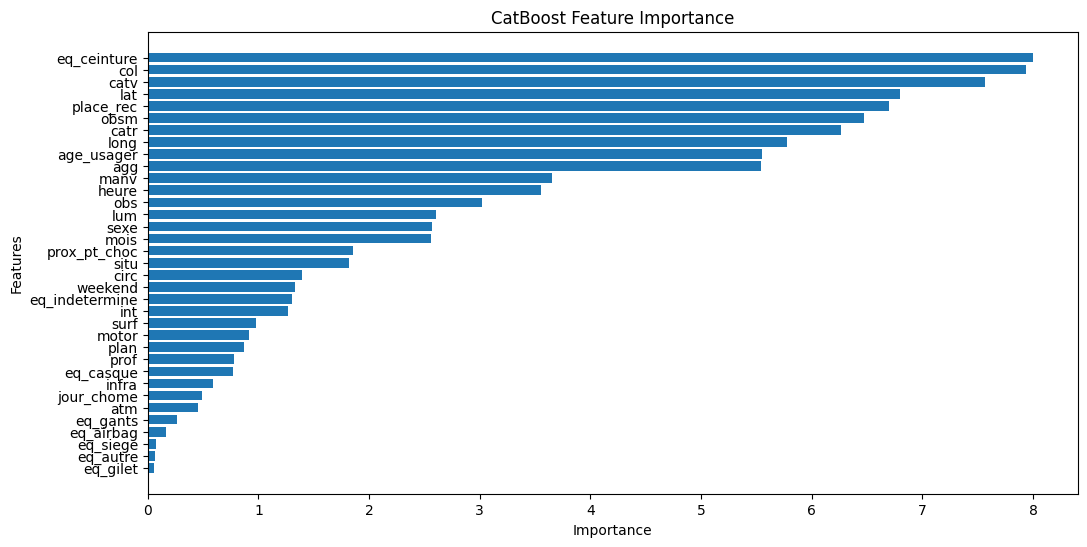

In [17]:
importances = model.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=data.columns).sort_values()
plt.figure(figsize=(12, 6))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig(conf['local_data_path'] + 'catboost_feature_importance' + '.jpg')

**shap values**

In [19]:
test_dataset = Pool(data = data_test,
                     label = y_test,
                     cat_features = categorical_numbers,
                     weight = y_test.map(class_weights))

In [20]:
shap_values = model.get_feature_importance(test_dataset,type='ShapValues')


In [22]:
shap_values.shape

(111784, 4, 36)

In [27]:
data_test.shape

(111784, 35)

In [41]:
# Shap ne reconnaît pas les var de type objet (affichage en gris)
data_test_fl = data_test.astype('float')

**Analyse des personnes indemnes**

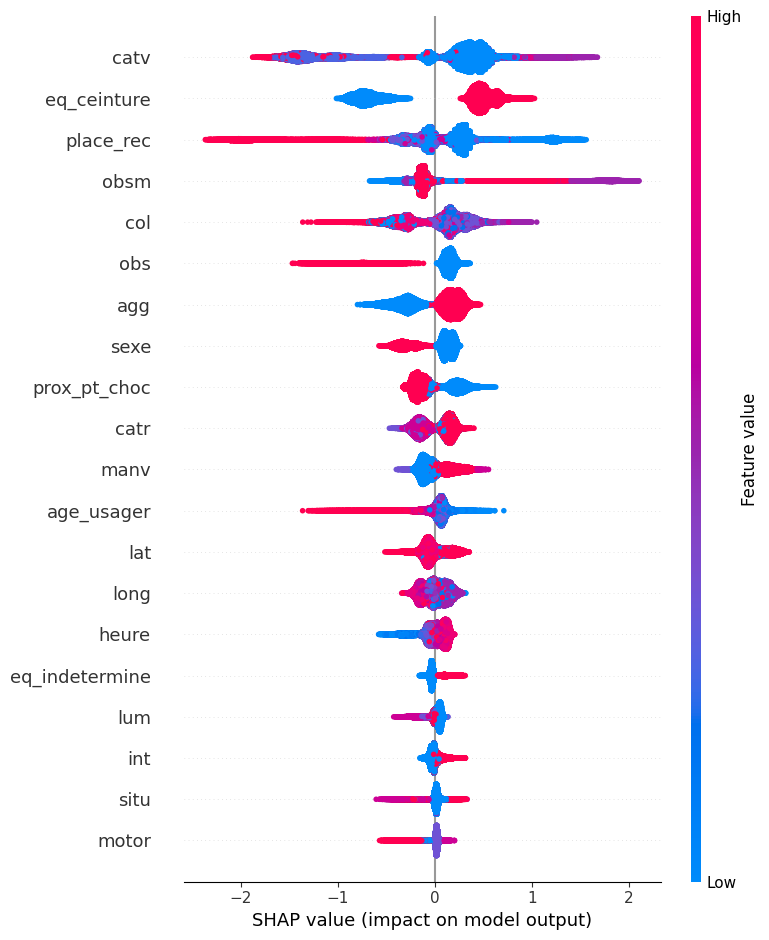

<Figure size 640x480 with 0 Axes>

In [45]:
shap.summary_plot(shap_values[:,0,:-1], data_test_fl)
plt.savefig('../../../data/img/' + f'catboost_shap_indemnes' + '.jpg')

**Analyse des personnes légèrement blessées**

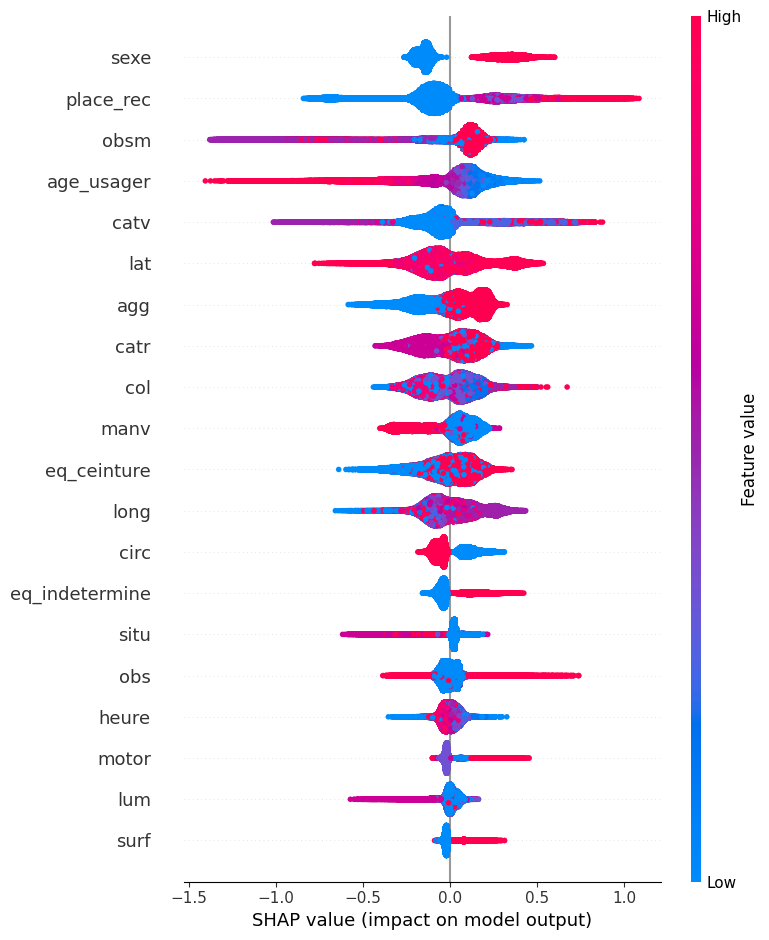

<Figure size 640x480 with 0 Axes>

In [46]:
shap.summary_plot(shap_values[:,1,:-1], data_test_fl)
plt.savefig('../../../data/img/' + f'catboost_shap_blesses' + '.jpg')

**Analyse des personnes gravement blessées**

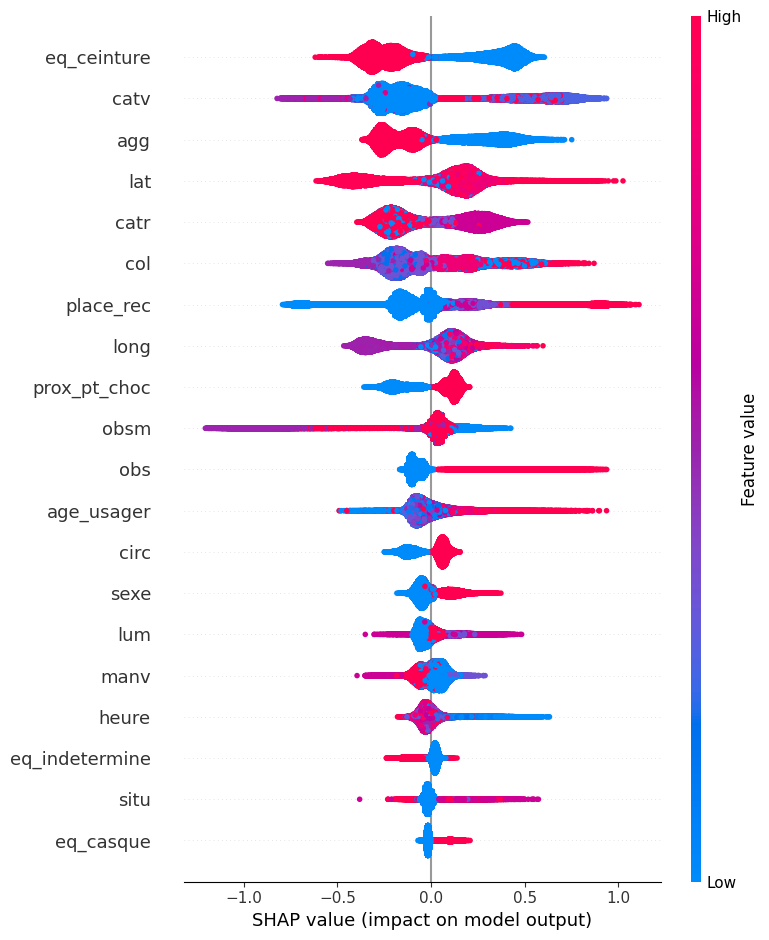

<Figure size 640x480 with 0 Axes>

In [48]:
shap.summary_plot(shap_values[:,2,:-1], data_test_fl)
plt.savefig('../../../data/img/' + f'catboost_shap_blessesgraves' + '.jpg')

**Analyse des personnes tuées**

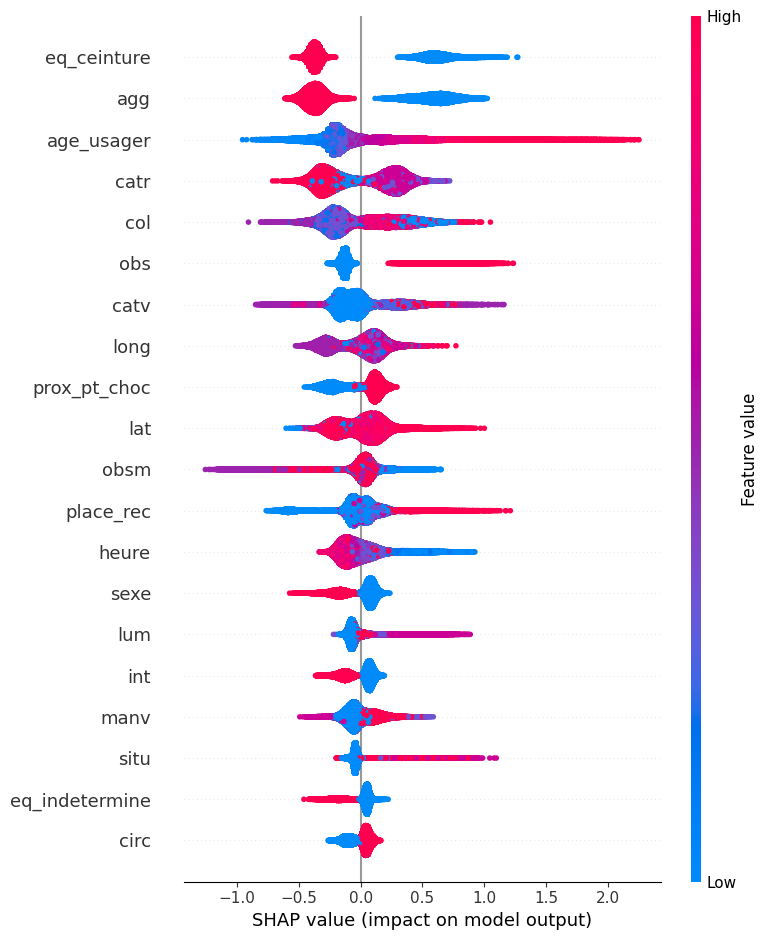

<Figure size 640x480 with 0 Axes>

In [49]:
shap.summary_plot(shap_values[:,3,:-1], data_test_fl)
plt.savefig('../../../data/img/' + f'catboost_shap_tues' + '.jpg')